# Bikes & Cycling Accessories Organisation's Transactions Data Based Cohort Analysis

# background
Sprocket Central Pty Ltd , a medium size bikes & cycling accessories organisation, has approached Tony Smith (Partner) in KPMG’s Lighthouse & Innovation Team. Sprocket Central Pty Ltd is keen to learn more about KPMG’s expertise in its Analytics, Information & Modelling team.

Primarily, Sprocket Central Pty Ltd needs help with its customer and transactions data. The organisation has a large dataset relating to its customers, but their team is unsure how to effectively analyse it to help optimise its marketing strategy.

# data
The client provided KPMG with 3 datasets:
Customer Demographic

Customer Addresses

Transactions data




# main idea for retention rate part

1.Extract the date, change the day to be first day of each month, create a new variable called 'transaction month',which allow us to use the data at month level

2.Group by 'customer id', extract min 'transaction month' to create a new variable called 'cohort month', which means the customer's registered month

3.Create a new variable called 'cohort index' by 'transaction month-cohort month +1',which means the customer keep using the app until xx month

4.Combine 'cohort month' and 'cohort index' and group by this cluster, extract unique number of customers to create a new variable called 'customer_id'

5.Draw a table with 'cohort month' as row name,'cohort index' as column name, 'customer_id'as value, so that rows are customer life cyle and columns are product lifecycle

6.Use first column as divisor to deal with all the values in the table, so that we get 'retention rate', means 'cohort xx retain in the xx(index) month'

7.visulize and interpret retention rate

## Part1.data loading and deal with missing data

In [1]:
# libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt

In [2]:
# load dataset
transaction_df = pd.read_excel('KPMG_VI_New_raw_data_update_final.xlsx','Transactions')
# view shape of the dataframe
print("Data loaded successfully. Shape:", transaction_df.shape)
# View data
transaction_df.head(3)

Data loaded successfully. Shape: (20001, 13)


,Note: The data and information in this document is reflective of a hypothetical situation and client. This document is to be used for KPMG Virtual Internship purposes only.,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12
0,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date
1,1,2,2950,2017-02-25 00:00:00,False,Approved,Solex,Standard,medium,medium,71.49,53.62,41245
2,2,3,3120,2017-05-21 00:00:00,True,Approved,Trek Bicycles,Standard,medium,large,2091.47,388.92,41701


In [3]:
# rename column name
transaction_df.columns = transaction_df.iloc[0]
# drop duplicate column
transaction_df.drop(index=transaction_df.index[0], axis=0, inplace=True)
transaction_df.head()

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date
1,1,2,2950,2017-02-25 00:00:00,False,Approved,Solex,Standard,medium,medium,71.49,53.62,41245
2,2,3,3120,2017-05-21 00:00:00,True,Approved,Trek Bicycles,Standard,medium,large,2091.47,388.92,41701
3,3,37,402,2017-10-16 00:00:00,False,Approved,OHM Cycles,Standard,low,medium,1793.43,248.82,36361
4,4,88,3135,2017-08-31 00:00:00,False,Approved,Norco Bicycles,Standard,medium,medium,1198.46,381.1,36145
5,5,78,787,2017-10-01 00:00:00,True,Approved,Giant Bicycles,Standard,medium,large,1765.3,709.48,42226


In [4]:
# check missing values before cleaning
print("Missing values before cleaning:", transaction_df.isna().values.sum(), "\n")

# ===== Step 1. Handle Numerical Missing Values =====
# replace empty strings (" ") with NaN, then fill with column mean
transaction_df = transaction_df.replace(" ", np.nan)  # convert blanks to NaN
transaction_df.fillna(transaction_df.mean(numeric_only=True), inplace=True)

print("After filling numerical NaN with column mean:",
      transaction_df.isna().values.sum(), "missing values remaining\n")

# ===== Step 2. Handle Categorical Missing Values =====
# fill NaN in categorical columns with the most frequent value (mode)
for column in transaction_df.columns:
    if transaction_df[column].dtype == 'object':  
        mode_value = transaction_df[column].mode()[0]  # get mode
        transaction_df[column].fillna(mode_value, inplace=True)

# final check
print("Missing values after categorical fill:",
      transaction_df.isna().values.sum(), "\n")

# ===== Step 3. Display before-after difference =====
print("Data preview after cleaning:")
print(transaction_df.head(3))

Missing values before cleaning: 1542 

After filling numerical NaN with column mean: 1542 missing values remaining

Missing values after categorical fill: 0 

Data preview after cleaning:
0 transaction_id product_id customer_id     transaction_date  online_order  \
1              1          2        2950  2017-02-25 00:00:00         False   
2              2          3        3120  2017-05-21 00:00:00          True   
3              3         37         402  2017-10-16 00:00:00         False   

0 order_status          brand product_line product_class product_size  \
1     Approved          Solex     Standard        medium       medium   
2     Approved  Trek Bicycles     Standard        medium        large   
3     Approved     OHM Cycles     Standard           low       medium   

0 list_price  standard_cost  product_first_sold_date  
1      71.49          53.62                    41245  
2    2091.47         388.92                    41701  
3    1793.43         248.82              

/var/folders/pl/_88ntt4s4nx7c1ycnhf3k5780000gn/T/ipykernel_10961/3362439822.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  transaction_df[column].fillna(mode_value, inplace=True)
/var/folders/pl/_88ntt4s4nx7c1ycnhf3k5780000gn/T/ipykernel_10961/3362439822.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


## Part2.EDA(histogram/line chart)

0
transaction_id              object
product_id                  object
customer_id                 object
transaction_date            object
online_order                  bool
order_status                object
brand                       object
product_line                object
product_class               object
product_size                object
list_price                  object
standard_cost              float64
product_first_sold_date      int64
dtype: object


/var/folders/pl/_88ntt4s4nx7c1ycnhf3k5780000gn/T/ipykernel_10961/1799875146.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax=sns.countplot(data=transaction_df, x='online_order', palette='pastel')


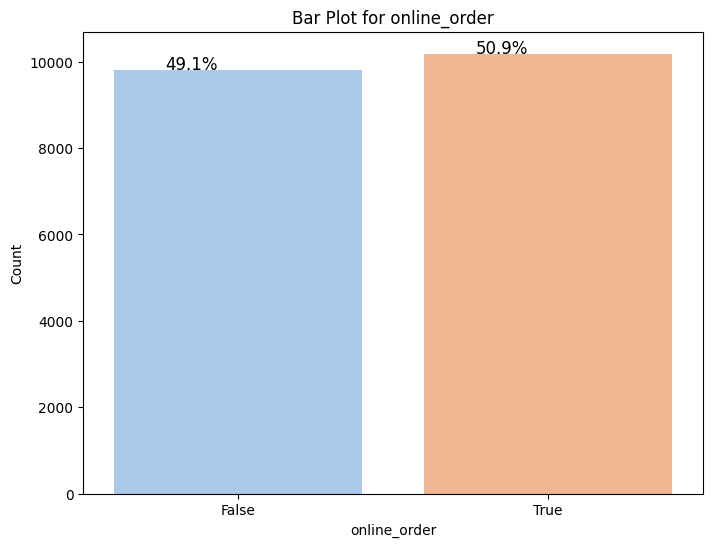

In [5]:

print(transaction_df.dtypes)
#for catogorical
plt.figure(figsize=(8, 6))
ax=sns.countplot(data=transaction_df, x='online_order', palette='pastel')
plt.title('Bar Plot for online_order')
plt.xlabel('online_order')
plt.ylabel('Count')
# Calculate percentages and add them to the bars
total_count = len(transaction_df)  # Total count of data points
# Loop through each bar in the countplot
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total_count)  # Calculate percentage
    x = p.get_x() + p.get_width() / 2 - 0.15  # Adjust the position for centering
    y = p.get_height() + 5  # Adjust the vertical position
    ax.annotate(percentage, (x, y), fontsize=12, ha='center')
plt.show()

In [6]:
# delete the unsual data
# if the data type is not a string, convert it to a string
if transaction_df['online_order'].dtype != 'str':
    transaction_df['online_order'] = transaction_df['online_order'].astype(str)
transaction_df=transaction_df[transaction_df['online_order'].isin(['True', 'False'])]

/var/folders/pl/_88ntt4s4nx7c1ycnhf3k5780000gn/T/ipykernel_10961/1186807346.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax=sns.countplot(data=transaction_df, x='order_status', palette='pastel')


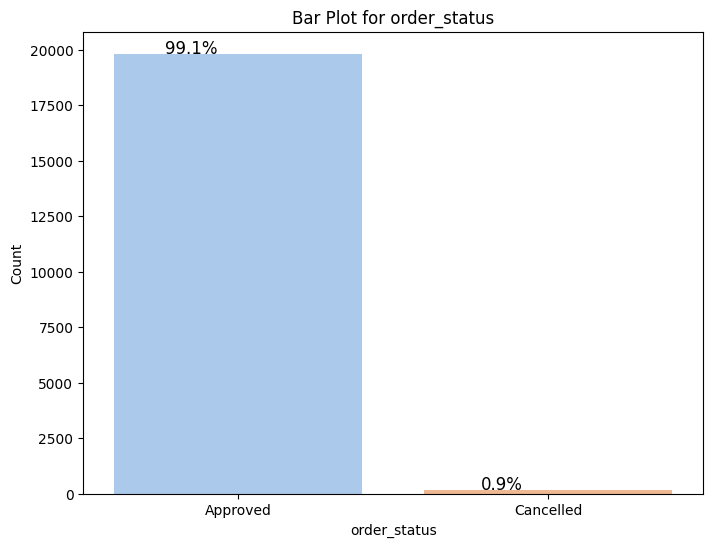

In [7]:
plt.figure(figsize=(8, 6))
ax=sns.countplot(data=transaction_df, x='order_status', palette='pastel')
plt.title('Bar Plot for order_status')
plt.xlabel('order_status')
plt.ylabel('Count')
# Calculate percentages and add them to the bars
total_count = len(transaction_df)  # Total count of data points
# Loop through each bar in the countplot
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total_count)  # Calculate percentage
    x = p.get_x() + p.get_width() / 2 - 0.15  # Adjust the position for centering
    y = p.get_height() + 5  # Adjust the vertical position
    ax.annotate(percentage, (x, y), fontsize=12, ha='center')
plt.show()

/var/folders/pl/_88ntt4s4nx7c1ycnhf3k5780000gn/T/ipykernel_10961/3112847623.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax=sns.countplot(data=transaction_df, x='brand', palette='pastel')


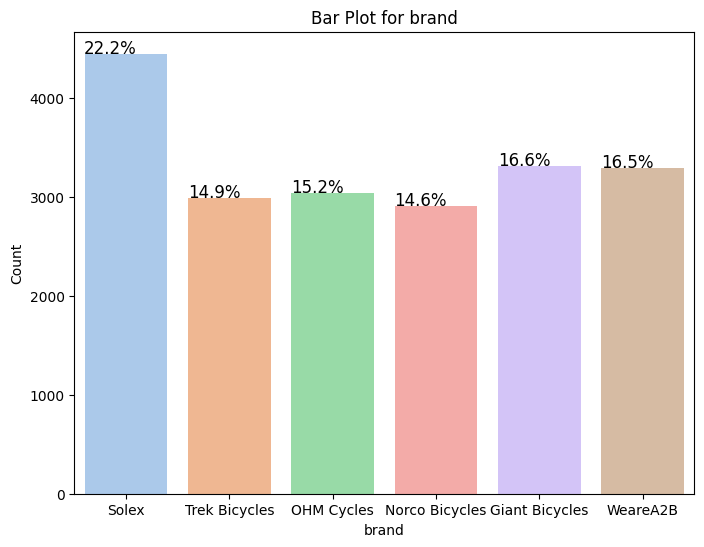

In [8]:
plt.figure(figsize=(8, 6))
ax=sns.countplot(data=transaction_df, x='brand', palette='pastel')
plt.title('Bar Plot for brand')
plt.xlabel('brand')
plt.ylabel('Count')
# Calculate percentages and add them to the bars
total_count = len(transaction_df)  # Total count of data points
# Loop through each bar in the countplot
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total_count)  # Calculate percentage
    x = p.get_x() + p.get_width() / 2 - 0.15  # Adjust the position for centering
    y = p.get_height() + 5  # Adjust the vertical position
    ax.annotate(percentage, (x, y), fontsize=12, ha='center')
plt.show()


/var/folders/pl/_88ntt4s4nx7c1ycnhf3k5780000gn/T/ipykernel_10961/737738035.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax=sns.countplot(data=transaction_df, x='product_line', palette='pastel')


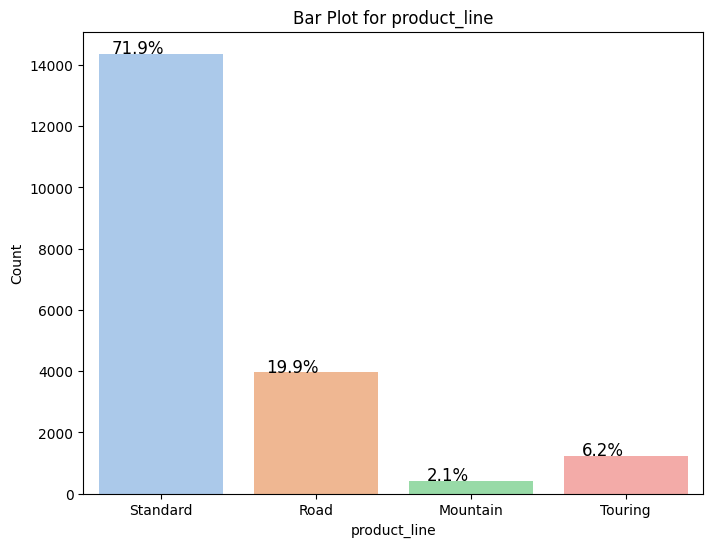

In [9]:
plt.figure(figsize=(8, 6))
ax=sns.countplot(data=transaction_df, x='product_line', palette='pastel')
plt.title('Bar Plot for product_line')
plt.xlabel('product_line')
plt.ylabel('Count')
# Calculate percentages and add them to the bars
total_count = len(transaction_df)  # Total count of data points
# Loop through each bar in the countplot
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total_count)  # Calculate percentage
    x = p.get_x() + p.get_width() / 2 - 0.15  # Adjust the position for centering
    y = p.get_height() + 5  # Adjust the vertical position
    ax.annotate(percentage, (x, y), fontsize=12, ha='center')
plt.show()

/var/folders/pl/_88ntt4s4nx7c1ycnhf3k5780000gn/T/ipykernel_10961/1246957581.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax=sns.countplot(data=transaction_df, x='product_class', palette='pastel')


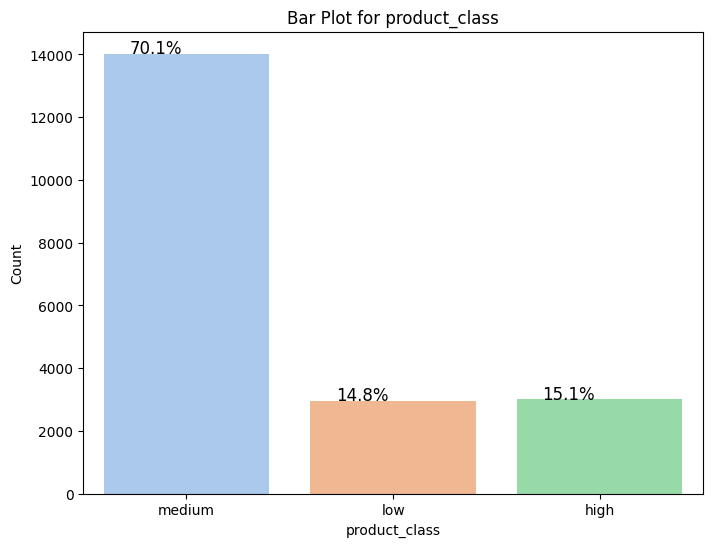

In [10]:
plt.figure(figsize=(8, 6))
ax=sns.countplot(data=transaction_df, x='product_class', palette='pastel')
plt.title('Bar Plot for product_class')
plt.xlabel('product_class')
plt.ylabel('Count')
# Calculate percentages and add them to the bars
total_count = len(transaction_df)  # Total count of data points
# Loop through each bar in the countplot
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total_count)  # Calculate percentage
    x = p.get_x() + p.get_width() / 2 - 0.15  # Adjust the position for centering
    y = p.get_height() + 5  # Adjust the vertical position
    ax.annotate(percentage, (x, y), fontsize=12, ha='center')
plt.show()

/var/folders/pl/_88ntt4s4nx7c1ycnhf3k5780000gn/T/ipykernel_10961/434354983.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax=sns.countplot(data=transaction_df, x='product_size', palette='pastel')


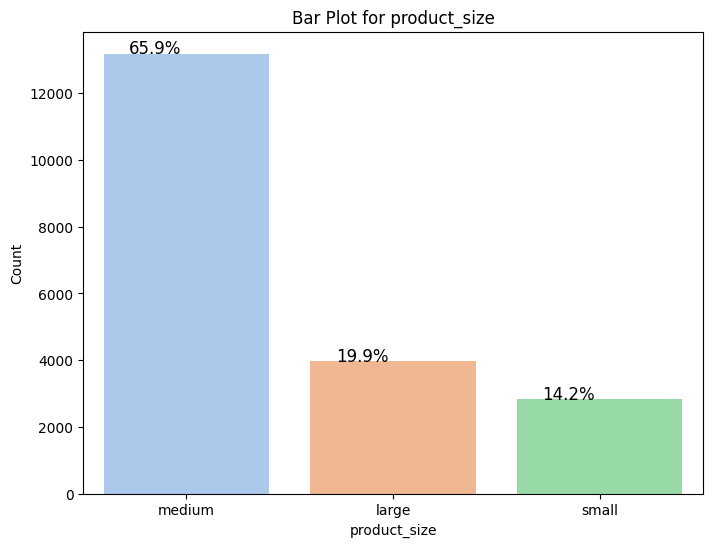

In [11]:
plt.figure(figsize=(8, 6))
ax=sns.countplot(data=transaction_df, x='product_size', palette='pastel')
plt.title('Bar Plot for product_size')
plt.xlabel('product_size')
plt.ylabel('Count')
# Calculate percentages and add them to the bars
total_count = len(transaction_df)  # Total count of data points
# Loop through each bar in the countplot
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total_count)  # Calculate percentage
    x = p.get_x() + p.get_width() / 2 - 0.15  # Adjust the position for centering
    y = p.get_height() + 5  # Adjust the vertical position
    ax.annotate(percentage, (x, y), fontsize=12, ha='center')
plt.show()

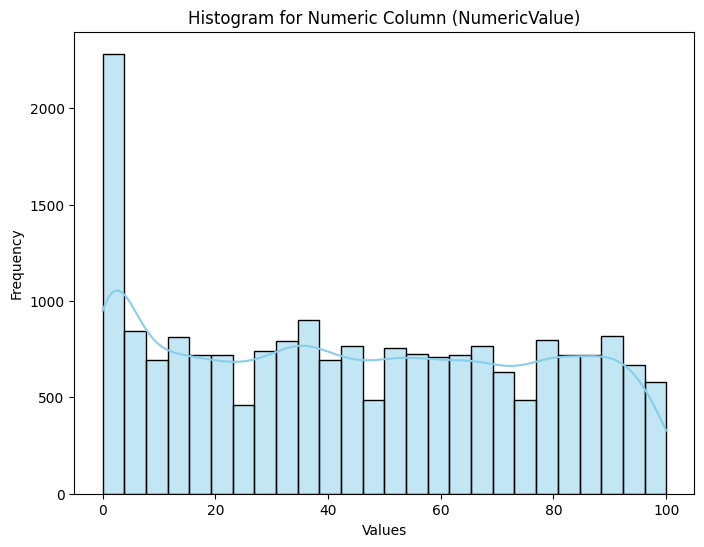

In [ ]:
#for numerical value
plt.figure(figsize=(8, 6))
sns.histplot(data=transaction_df, x='product_id', kde=True, color='skyblue')
plt.title('Histogram for Numeric Column (NumericValue)')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.show()

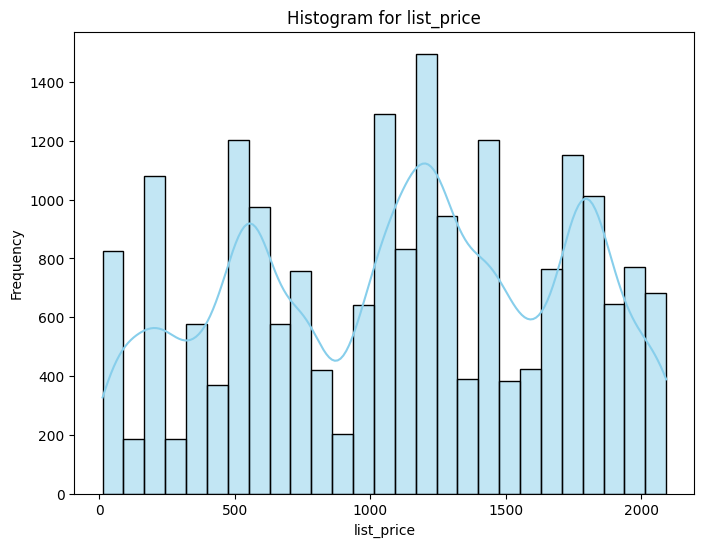

In [13]:
plt.figure(figsize=(8, 6))
sns.histplot(data=transaction_df, x='list_price', kde=True, color='skyblue')
plt.title('Histogram for list_price')
plt.xlabel('list_price')
plt.ylabel('Frequency')
plt.show()

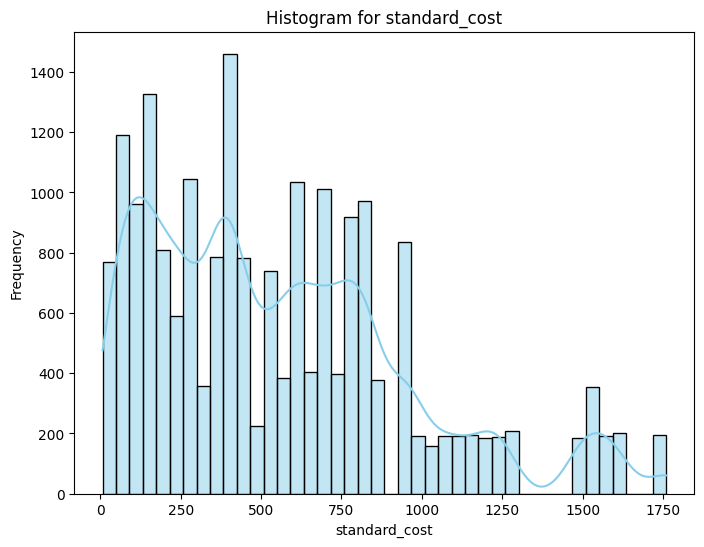

In [14]:
plt.figure(figsize=(8, 6))
sns.histplot(data=transaction_df, x='standard_cost', kde=True, color='skyblue')
plt.title('Histogram for standard_cost')
plt.xlabel('standard_cost')
plt.ylabel('Frequency')
plt.show()

### we could see that
For online_order or not,consumers are 50% purchased through online order, 50% are not

For order_status,almost all(99.1%) the consumers' order are approved

For brand,there are 6 brands,among which solex accounts the most with 22%, other brands have similar sales volumn

For product line, most people(71.9%) bought standard bikes and 1/5 people use them for road

For product class, most people(70.2%) prefer medium class

For product size, most people(66%) bought medium bikes

## Part3.Assigned the cohorts and calculated the monthly offset

In [15]:
# change transaction_date in a formal way
transaction_df['transaction_date']#check specific value
# convert the 'date' column to a datetime data type if it's not already
transaction_df['transaction_date'] = pd.to_datetime(transaction_df['transaction_date'])
# format the date as 'YYYY-MM-DD'
transaction_df['transaction_date'] = transaction_df['transaction_date'].dt.strftime('%Y-%m-%d')

In [16]:
# convert the 'date' column to a datetime data type if it's not already
transaction_df['transaction_date'] = pd.to_datetime(transaction_df['transaction_date'])
# create a new variable called transaction_month
transaction_df['transaction_month'] = transaction_df['transaction_date'].dt.strftime('%Y-%m-01')

In [17]:
#create a new variable called cohort_month:for one user, choose the first month of all transaction month to be the cohort month
print(transaction_df.groupby('customer_id')['transaction_month'].transform('min'))#transform brings back the value
transaction_df['cohort_month']=transaction_df.groupby('customer_id')['transaction_month'].transform('min')

1        2017-02-01
2        2017-01-01
3        2017-01-01
4        2017-02-01
5        2017-01-01
            ...    
19996    2017-01-01
19997    2017-01-01
19998    2017-04-01
19999    2017-02-01
20000    2017-03-01
Name: transaction_month, Length: 20000, dtype: object


In [18]:
#create a new variable called cohort_index,difference between two variables
transaction_df['year_difference']=pd.to_datetime(transaction_df['transaction_month']).dt.year-pd.to_datetime(transaction_df['cohort_month']).dt.year
transaction_df['month_difference']=pd.to_datetime(transaction_df['transaction_month']).dt.month-pd.to_datetime(transaction_df['cohort_month']).dt.month
transaction_df['cohort_index']=transaction_df['year_difference']*12+transaction_df['month_difference']+1#cohort index=1 means this is the first month after registered
transaction_df

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date,transaction_month,cohort_month,year_difference,month_difference,cohort_index
1,1,2,2950,2017-02-25,False,Approved,Solex,Standard,medium,medium,71.49,53.62,41245,2017-02-01,2017-02-01,0,0,1
2,2,3,3120,2017-05-21,True,Approved,Trek Bicycles,Standard,medium,large,2091.47,388.92,41701,2017-05-01,2017-01-01,0,4,5
3,3,37,402,2017-10-16,False,Approved,OHM Cycles,Standard,low,medium,1793.43,248.82,36361,2017-10-01,2017-01-01,0,9,10
4,4,88,3135,2017-08-31,False,Approved,Norco Bicycles,Standard,medium,medium,1198.46,381.10,36145,2017-08-01,2017-02-01,0,6,7
5,5,78,787,2017-10-01,True,Approved,Giant Bicycles,Standard,medium,large,1765.3,709.48,42226,2017-10-01,2017-01-01,0,9,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19996,19996,51,1018,2017-06-24,True,Approved,OHM Cycles,Standard,high,medium,2005.66,1203.40,37823,2017-06-01,2017-01-01,0,5,6
19997,19997,41,127,2017-11-09,True,Approved,Solex,Road,medium,medium,416.98,312.74,35560,2017-11-01,2017-01-01,0,10,11
19998,19998,87,2284,2017-04-14,True,Approved,OHM Cycles,Standard,medium,medium,1636.9,44.71,40410,2017-04-01,2017-04-01,0,0,1
19999,19999,6,2764,2017-07-03,False,Approved,OHM Cycles,Standard,high,medium,227.88,136.73,38216,2017-07-01,2017-02-01,0,5,6


In [ ]:
# ===== Step 1. Create TransactionMonth =====
def get_month(x):
    """Convert any date to the first day of its month (for monthly grouping)."""
    return dt.datetime(x.year, x.month, 1)
# convert raw transaction date into monthly cohort key
transaction_df['TransactionMonth'] = transaction_df['transaction_date'].apply(get_month)

# ===== Step 2. Define CohortMonth =====
# assign each customer to the month of their first purchase
transaction_df['CohortMonth'] = (transaction_df.groupby('customer_id')['TransactionMonth'].transform('min'))

# ===== Step 3. Extract date components =====
def get_date_int(df, column):
    """Extract year, month, and day integers from a datetime column."""
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.day
    return year, month, day
# extract year/month for transactions and cohorts
trans_year, trans_month, _ = get_date_int(transaction_df, 'TransactionMonth')
cohort_year, cohort_month, _ = get_date_int(transaction_df, 'CohortMonth')

# ===== Step 4. Compute CohortIndex =====
# CohortIndex = months between first purchase and current purchase
years_diff = trans_year - cohort_year
months_diff = trans_month - cohort_month
transaction_df['CohortIndex'] = years_diff * 12 + months_diff + 1

# ===== Step 5. Aggregate cohort data =====
# count unique users per CohortMonth & CohortIndex
cohort_data = (
transaction_df.groupby(['CohortMonth', 'CohortIndex']) 
 .nunique()['customer_id']
 .reset_index()
 .rename(columns={'customer_id': 'UniqueCustomers'})
)
# preview result
print(f"Cohort Data Sample:\n {cohort_data.head()}")

Cohort Data Sample:
   CohortMonth  CohortIndex  UniqueCustomers
0  2017-01-01            1             1354
1  2017-01-01            2              486
2  2017-01-01            3              508
3  2017-01-01            4              509
4  2017-01-01            5              502


## Part4.Calculate Business metrics:retention rate

In [19]:
#create customer_id: unique customer in each combination of cohort_month and cohort_index
transaction_df.groupby(['cohort_month','cohort_index'])['customer_id'].nunique().reset_index()
new_data=transaction_df.groupby(['cohort_month','cohort_index'])['customer_id'].nunique().reset_index()

In [20]:
#create the table
pivot_table=pd.DataFrame(new_data).pivot(index='cohort_month',columns='cohort_index',values='customer_id')
pivot_table

cohort_index,1,2,3,4,5,6,7,8,9,10,11,12
cohort_month,,,,,,,,,,,,
2017-01-01,1354.0,486.0,508.0,509.0,502.0,483.0,518.0,529.0,500.0,531.0,497.0,516.0
2017-02-01,800.0,325.0,298.0,313.0,288.0,298.0,308.0,281.0,329.0,308.0,296.0,NaN
2017-03-01,484.0,167.0,174.0,167.0,182.0,184.0,172.0,212.0,189.0,181.0,NaN,NaN
2017-04-01,336.0,111.0,121.0,153.0,143.0,121.0,142.0,126.0,132.0,NaN,NaN,NaN
2017-05-01,210.0,85.0,81.0,87.0,71.0,74.0,73.0,81.0,NaN,NaN,NaN,NaN
2017-06-01,122.0,45.0,44.0,47.0,46.0,46.0,53.0,NaN,NaN,NaN,NaN,NaN
2017-07-01,77.0,26.0,29.0,32.0,37.0,24.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-01,51.0,19.0,21.0,17.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09-01,23.0,7.0,7.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
pivot_table.iloc[:,0]

cohort_month
2017-01-01    1354.0
2017-02-01     800.0
2017-03-01     484.0
2017-04-01     336.0
2017-05-01     210.0
2017-06-01     122.0
2017-07-01      77.0
2017-08-01      51.0
2017-09-01      23.0
2017-10-01      20.0
2017-11-01      13.0
2017-12-01       4.0
Name: 1, dtype: float64

In [22]:
#use the first column as baseline
pivot_table.iloc[:, 1:]=pivot_table.iloc[:, 1:].div(pivot_table.iloc[:,0], axis=0).round(3)*100
pivot_table.iloc[:, 0]=100
pivot_table

cohort_index,1,2,3,4,5,6,7,8,9,10,11,12
cohort_month,,,,,,,,,,,,
2017-01-01,100.0,35.9,37.5,37.6,37.1,35.7,38.3,39.1,36.9,39.2,36.7,38.1
2017-02-01,100.0,40.6,37.2,39.1,36.0,37.2,38.5,35.1,41.1,38.5,37.0,NaN
2017-03-01,100.0,34.5,36.0,34.5,37.6,38.0,35.5,43.8,39.0,37.4,NaN,NaN
2017-04-01,100.0,33.0,36.0,45.5,42.6,36.0,42.3,37.5,39.3,NaN,NaN,NaN
2017-05-01,100.0,40.5,38.6,41.4,33.8,35.2,34.8,38.6,NaN,NaN,NaN,NaN
2017-06-01,100.0,36.9,36.1,38.5,37.7,37.7,43.4,NaN,NaN,NaN,NaN,NaN
2017-07-01,100.0,33.8,37.7,41.6,48.1,31.2,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-01,100.0,37.3,41.2,33.3,25.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09-01,100.0,30.4,30.4,39.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Part5.Visualize the retention rate

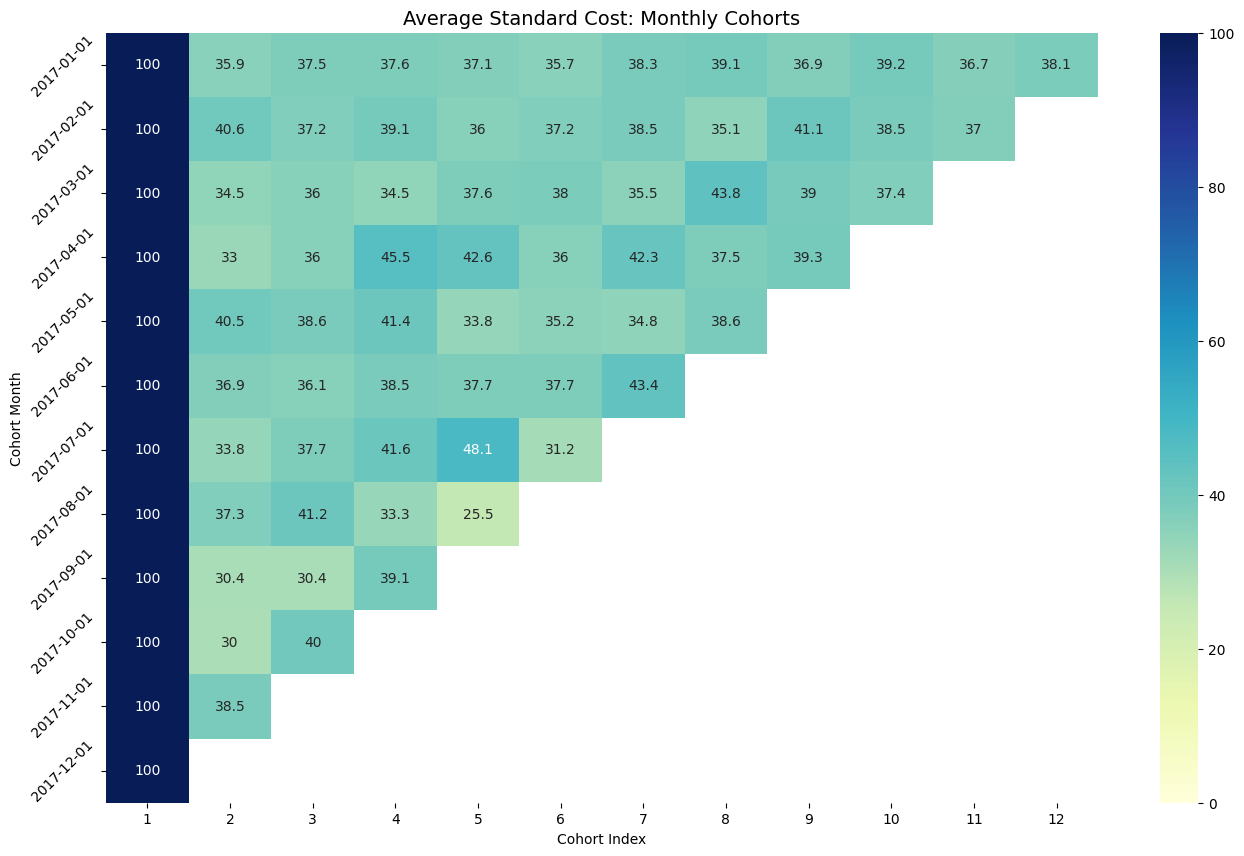

In [23]:
# Initialize the figure
plt.figure(figsize=(16, 10))
# Adding a title
plt.title('Average Standard Cost: Monthly Cohorts', fontsize = 14)
# Creating the heatmap
sns.heatmap(pivot_table, annot = True,vmin = 0.0, vmax =100,cmap="YlGnBu", fmt='g')
plt.ylabel('Cohort Month')
plt.xlabel('Cohort Index')
plt.yticks( rotation=45)
plt.show()

### a.Interpreting the retention rate
The most effective way to visualize and analyze cohort analysis data is through a heatmap, as we did above. It provides both the actual metric values and the color-coding to see the differences in the numbers visually

The retention rate of each cohort has trends to go up and down.If we observe the data by each row, we can catch the pattern of each cohort over time; if we observe the data by each column, we can catch the pattern of product life.



### b.Interesting fact

1.Data remained between 27.8% and 47.6%.The first column, which cohort index equals to 1 has all value 100%, means all customers were retained at the first month when they started to buy the bike

2.The largest value occurs in cohort 2017-07-01 with index 5, which means 47.6% of customers who registered at 2017-07-01 retained at 5th month

3.The largest value occurs in cohort 2017-07-01 with index 5, which means 47.6% of customers who registered at 2017-07-01 retained at 5th month

### c.Draw line chart for retention rate(of each cohort)

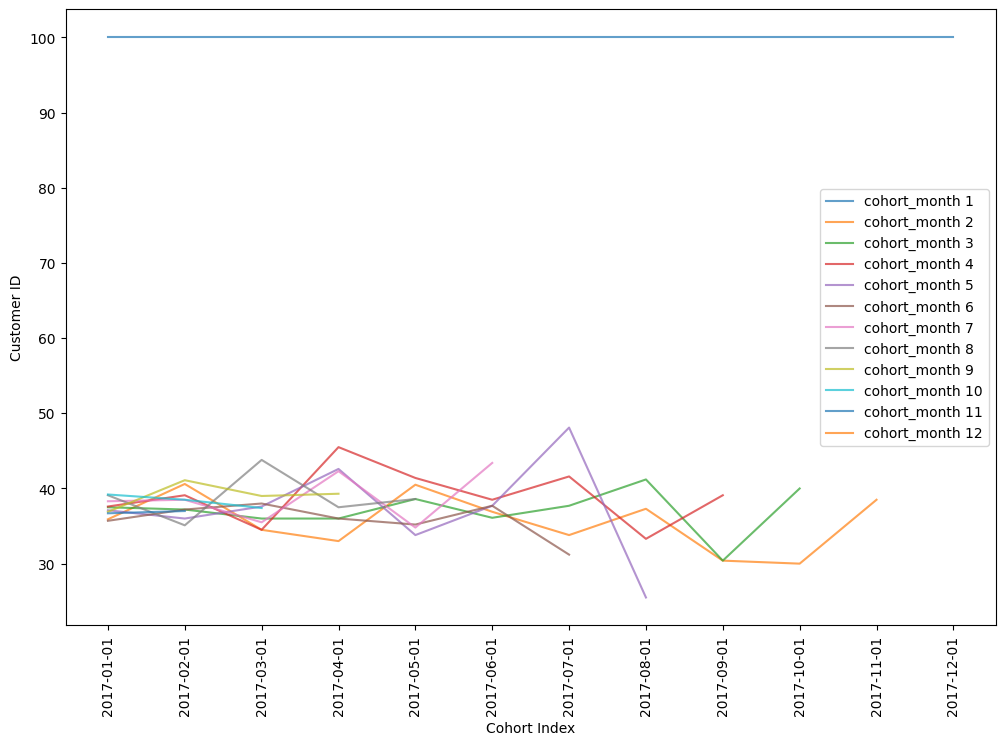

In [24]:
# Plot each 'cohort_month' as a separate line
plt.figure(figsize=(12, 8))

#The column variable is assumed to be a loop variable that iterates through the column names of the DataFrame. It represents the current column being processed in each iteration of the loop.
for column in pivot_table.columns:
    plt.plot(pivot_table.index, pivot_table[column], label=f"cohort_month {column}",alpha=0.7)
   
# Add labels and a legend
plt.xticks(rotation='vertical')
plt.xlabel("Cohort Index")
plt.ylabel("Customer ID")
plt.legend()
plt.show()

Overall, their retention rate is around some value 30%-40%.

Compared to other cohorts,cohort '2017-08-01' shows relatively different trends,especially with cohort '2017-04-01' Maybe there are some hidden reasons